# Decision Tree

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# dataset
df = pd.read_csv("../dataset/satellite_signal_dataset.csv")
df.head()

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor


In [3]:
# target encoding..
labels, uniques = pd.factorize(df['signal_quality'])
X = pd.get_dummies(df.drop(columns=['signal_quality']), drop_first=True).values
y = labels

In [4]:
# train-test split
np.random.seed(42)
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8*len(X))
train_idx, test_idx = idx[:split], idx[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [9]:
# --- Decision Tree ---
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def gini(y):
    m = len(y)
    if m == 0:
        return 0.0
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def grow_tree(X, y, depth=0, max_depth=5):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = Node(
        gini=gini(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )
    if depth < max_depth:
        idx, thr = best_split(X, y)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            if len(X_left) > 0 and len(X_right) > 0: # Only split if both sides have data
                node.feature_index = idx
                node.threshold = thr
                node.left = grow_tree(X_left, y_left, depth + 1, max_depth)
                node.right = grow_tree(X_right, y_right, depth + 1, max_depth)
    return node

def best_split(X, y):
    m, n = X.shape
    if m <= 1:
        return None, None
    gini_parent = gini(y)
    best_gini = 1.0
    best_idx, best_thr = None, None
    classes = np.unique(y)
    num_classes = len(classes)

    # Map original labels to 0-based indices
    label_map = {label: i for i, label in enumerate(classes)}
    y_mapped = np.array([label_map[label] for label in y])


    for idx in range(n):
        thresholds, sorted_y = zip(*sorted(zip(X[:, idx], y_mapped)))
        num_left = [0] * num_classes
        num_right = [np.sum(y_mapped == i) for i in range(num_classes)] # Initialize with counts of mapped labels

        for i in range(1, m):
            c_mapped = sorted_y[i - 1] # Use mapped label
            num_left[c_mapped] += 1
            num_right[c_mapped] -= 1
            gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(num_classes)) # Iterate through 0-based indices
            gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(num_classes)) # Iterate through 0-based indices
            gini_total = (i * gini_left + (m - i) * gini_right) / m
            if thresholds[i] == thresholds[i - 1]:
                continue
            if gini_total < best_gini:
                best_gini = gini_total
                best_idx = idx
                best_thr = (thresholds[i] + thresholds[i - 1]) / 2
    return best_idx, best_thr

def predict_one(node, x):
    while node.left:
        if x[node.feature_index] < node.threshold:
            node = node.left
        else:
            node = node.right
    return node.predicted_class

def predict(tree, X):
    return [predict_one(tree, x) for x in X]

In [10]:
# applying DT...
tree = grow_tree(X_train, y_train)

In [11]:
# prediciton on test data
y_pred = predict(tree, X_test)

In [12]:
# evaluation metrics
accuracy = np.mean(y_pred == y_test)
precision, recall = [], []
for c in np.unique(y_test):
    tp = np.sum((y_pred == c) & (y_test == c))
    fp = np.sum((y_pred == c) & (y_test != c))
    fn = np.sum((y_pred != c) & (y_test == c))
    precision.append(tp / (tp + fp + 1e-9))
    recall.append(tp / (tp + fn + 1e-9))

print("Accuracy:", accuracy)
print("Precision per class:", precision)
print("Recall per class:", recall)

Accuracy: 0.8125
Precision per class: [np.float64(0.8124999999997968), np.float64(0.0), np.float64(0.0)]
Recall per class: [np.float64(0.9999999999996924), np.float64(0.0), np.float64(0.0)]


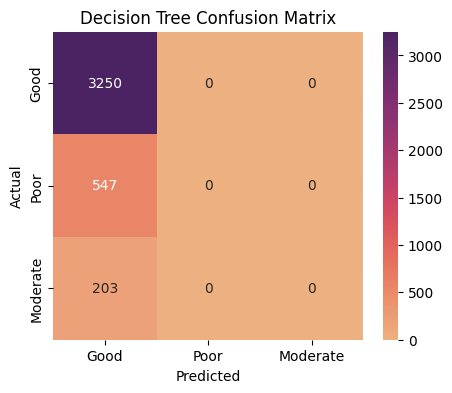

In [14]:
# confusion matrix.
cm = np.zeros((len(np.unique(y_test)), len(np.unique(y_test))), dtype=int)
for t, p in zip(y_test, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=uniques, yticklabels=uniques)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

### Plots

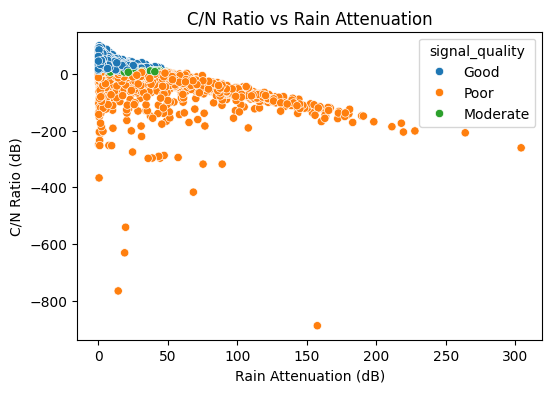

In [15]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['rain_attenuation_db'], y=df['cn_ratio_db'], hue=df['signal_quality'])
plt.xlabel("Rain Attenuation (dB)")
plt.ylabel("C/N Ratio (dB)")
plt.title("C/N Ratio vs Rain Attenuation")
plt.show()

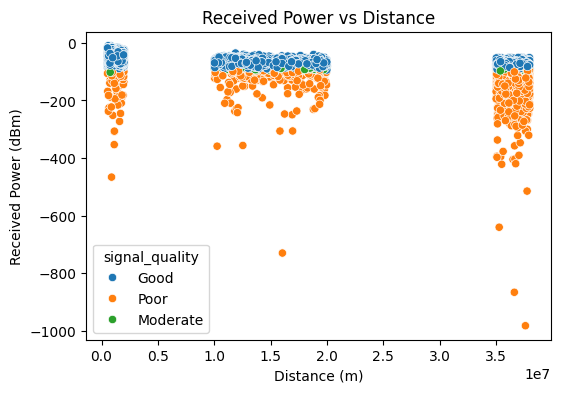

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['distance_m'], y=df['received_power_dbm'], hue=df['signal_quality'])
plt.xlabel("Distance (m)")
plt.ylabel("Received Power (dBm)")
plt.title("Received Power vs Distance")
plt.show()

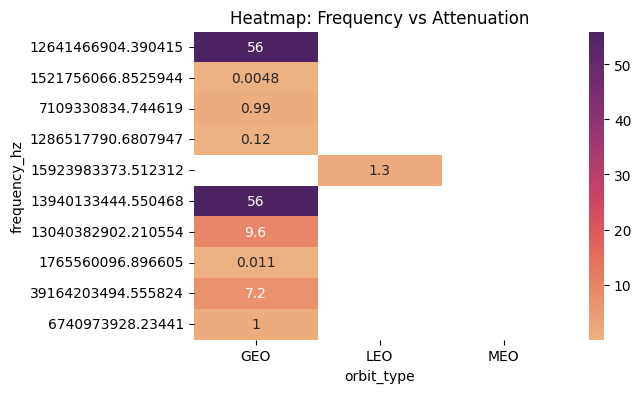

In [18]:
plt.figure(figsize=(6,4))
heatmap_data = df.pivot_table(values="rain_attenuation_db",
                              index="frequency_hz",
                              columns="orbit_type",
                              aggfunc="mean")
# Sample the heatmap data to reduce clutter on the y-axis
sampled_heatmap_data = heatmap_data.sample(n=10, random_state=42) # Sample 10 frequencies

sns.heatmap(sampled_heatmap_data, cmap="flare", annot=True)
plt.title("Heatmap: Frequency vs Attenuation")
plt.show()